## Ungraded RL Exercises 4: Continuous Glucose Monitoring (CGM) with Experience Replay

### University of Virginia
### Reinforcement Learning
#### Last updated: July 16, 2025

---

#### CGM Background

For Type I Diabetes (T1D) patients, they are not able to produce sufficient insulin to keep glucose in a safe range. Patients must use a method to inject insulin and monitor glucose levels. CGM systems are devices that track blood sugar levels continuously, providing real-time data to help individuals manage diabetes.

#### About this Exercise

The code in this exercise will simulate CGM values (the *state*), give insulin (the *action*), store the data (state, action, reward, next state) in a replay buffer, and periodically sample it for "training."


![cgm_monitor](./cgm_monitor.png)

This image shows a person wearing a patch that holds:  
- The sensor: a tiny filament (about the width of a hair) that painlessly sits just under the skin.
- The transmitter: electronics that read the glucose data from the sensor and send it wirelessly (via Bluetooth or NFC) to your phone, reader, or pump.

The monitor receives data from the transmitter and displays it on the device.

---


### Tasks

1 | Run the code and notice the average sampled reward and the plot.

2 | Print the experiences (state, action, reward, next state) and check that they make sense (e.g., do the actions taken make sense given the state?).

3 | Make changes to *insulin_policy()* to see if you can [1] make the reward worse [2] improve the reward. 

In practice, you would train an actual model, but this is outside the scope of this small exercise.

---

#### Code

In [1]:
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
target_cgm = 100 # the glucose value to target

Step 20: Avg sampled reward = -40.90
Step 40: Avg sampled reward = -50.98
Step 60: Avg sampled reward = -46.12
Step 80: Avg sampled reward = -40.13


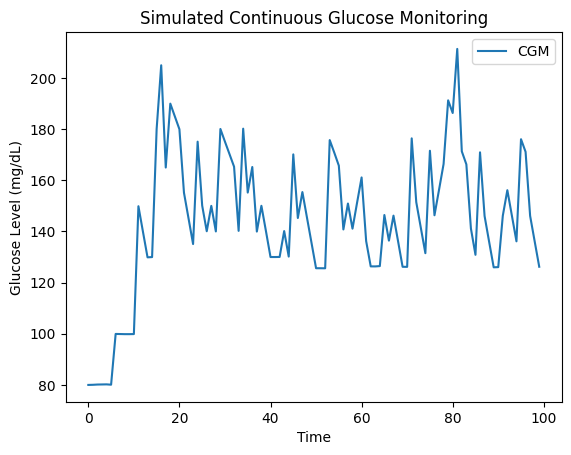

In [6]:
# Experience Replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size=32):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))


# Simulate CGM change with insulin effect
def simulate_cgm_reading(prev_value, insulin_action):
    # Insulin action: 0 (none), 1 (low), 2 (med), 3 (high)
    insulin_effect = [0, -10, -25, -40][insulin_action]

    # Meal spike + random noise
    meal_spike = random.choices([0, 20, 50], weights=[0.7, 0.2, 0.1])[0]
    noise = np.random.normal(loc=0, scale=0.1)

    new_value = prev_value + meal_spike + noise + insulin_effect
    return max(40, new_value)

# Select insulin dose based on simple threshold rule
def insulin_policy(cgm_value):
    if cgm_value > 200:
        return 3
    elif cgm_value > 160:
        return 2
    elif cgm_value > 130:
        return 1
    else:
        return 0

# Main loop
def run_simulation(steps=100):
    replay_buffer = ReplayBuffer(capacity=500)
    cgm_values = []
    insulin_doses = []
    prev_cgm = 80  # starting glucose level

    for t in range(steps):
        action = insulin_policy(prev_cgm)
        curr_cgm = simulate_cgm_reading(prev_cgm, action)

        # Reward: penalize high glucose
        reward = -abs(curr_cgm - target_cgm)

        # Store experience
        state = np.array([prev_cgm])
        next_state = np.array([curr_cgm])
        replay_buffer.add((state, action, reward, next_state))

        # Sample & "train"
        if t % 20 == 0 and len(replay_buffer.buffer) >= 20:
            batch = replay_buffer.sample(16)
            avg_reward = np.mean([val[2] for val in batch])
            print(f"Step {t}: Avg sampled reward = {avg_reward:.2f}")

        cgm_values.append(curr_cgm)
        insulin_doses.append(action)
        prev_cgm = curr_cgm
    
    # Plot the CGM readings
    plt.plot(cgm_values, label="CGM")
    plt.xlabel("Time")
    plt.ylabel("Glucose Level (mg/dL)")
    plt.title("Simulated Continuous Glucose Monitoring")
    plt.legend()
    plt.show()

run_simulation()
